# This Notebook purpose for Test Different Framework/tool for Document Analysis.
## Not focus on  implementation full flow of Document RAG processing

In [1]:
import os, json, time
import gc
from IPython.display import display, Markdown 
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import asyncio

In [2]:
class CFG:
    OFFLINE = False #True # for Test offline environment
    USE_LLAMA3 = False # 
    USE_GEMMA2 = False # 
    USE_QWEN = False # 
    USE_DEEPSEEK = True # 
    USE_DEEPSCALE = False # 

    TASK_GEN = True # for generative Text output task (suitable for RAG project)
    TEST_LLM = True
    USE_HUGGINGFACE = True # Pull model from Huggingface model hub
    USE_LMSTUIDO = False # for local LLM framework 
    USE_OLLAMA = False # for OLLAMA local LLM framework 
    USE_VLLM = False # for VLLM  LLM framework

    # mulitlingual LLM model 
    model1 = "meta-llama/Llama-3.2-3B-Instruct"  # llama3.2  3B-Instruct

    model2 =  "google/gemma-2-2b-it" # gemma 2 9B (mulitlingual)
    model3 = "Qwen/Qwen2.5-3B-Instruct" # Qwen 3B (mulitlingual)
    model4 = 'Qwen/Qwen2.5-7B-Instruct' # Qwen 7B (mulitlingual)
    model5 = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" # DeepSeek Distill 1.5B (mulitlingual)
    model6 = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" # DeepSeek Distill 7B (mulitlingual)
    model7 = "agentica-org/DeepScaleR-1.5B-Preview"

    # for VLM model
    vlmModel1 = "Qwen/Qwen2.5-VL-3B-Instruct"
    vlmModel2 = "Qwen/Qwen2.5-VL-7B-Instruct"


    # Mult Embedding model
    embedModel1 = 'intfloat/multilingual-e5-small' # for embedding model support chinese
    embedModel2 = "intfloat/multilingual-e5-large-instruct"
    embedModel3 = "Alibaba-NLP/gte-Qwen2-1.5B-instruct" # for embedding model support chinese
    embedModel4 = "Alibaba-NLP/gte-multilingual-base" # for embedding model support chinese
    embedModel5 = "BAAI/bge-m3" # for multilingual embedding model
    embedModel6 = "jinaai/jina-embeddings-v3"
    


    FEW_SHOT_TEST= False#True
    USE_WANDB = True#True # for  LLM evalution and debug , track fine tuning performance

    USE_DEEPEVAL = True#False # for LLM evalution   
    USE_TRAIN =  False #True #False#True Much be use GPU for Training 
    
    # For VectorDB selection
    USE_FAISS = False#True # For RAG VectorDB
    USE_CHROMA = True #False #True #False # for RAG VectorDF
    USE_PINECONE = False#True#False #True # for RAG VectorDF
    USE_WEAVIATE = False#True #False # for RAG VectorDF
    USE_MILVUS = False#True              # for RAG VectorDF

    # for LLM fine tuning
    maxTrainData = 200#3500#5000 #10000#5000 #10000
    maxEvalData = 20#100 # 20 


    # LLM parameters
    reportTo ="none"
    topK = 40
    topP = 1.0
    temperature = 0.6 #0.5
    repetition_penalty = 1.05 # 1.1
    maxOutToken = 1024#180 #100
    

    
    maxToken=  512#768#512#768 # 512 for test only

In [3]:
import numpy as np
import pandas as pd
import transformers
import torch
from transformers import (AutoTokenizer, 
                          BitsAndBytesConfig,
                         AutoModelForCausalLM,
                         TrainingArguments)

from langchain_community.document_loaders import (TextLoader,
                                                  PyMuPDFLoader,
                                                  PyPDFDirectoryLoader,
                                                  PyPDFLoader)

# from langchain.document_loaders import PyPDFDirectoryLoader # old version of document loader

from langchain.prompts.prompt import  PromptTemplate

from langchain_community.vectorstores import FAISS #, Chroma,  Pinecone # old version of VectorStore



from langchain_text_splitters import (RecursiveCharacterTextSplitter,
                                      CharacterTextSplitter ,
                                       SentenceTransformersTokenTextSplitter)   


# from langchain.embeddings import HuggingFaceEmbeddings # huggingfaceEmbedding deprecated , please use sentencetransformers 
from sentence_transformers import SentenceTransformer
from langchain_huggingface import HuggingFaceEmbeddings

from datasets import Dataset, DatasetDict, load_dataset


import evaluate
import trulens
import nest_asyncio
nest_asyncio.apply()

/home/johnsonhk88/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/johnsonhk88/.local/lib/python3.10/site-packages/langchain_huggingface/chat_models/__init__.py:1: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you ar

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
import ctypes
def clearMemory():
    for _ in range(5):
        torch.cuda.empty_cache()
        ctypes.CDLL("libc.so.6").malloc_trim(0)
        gc.collect()
        time.sleep(0.3)

In [6]:
clearMemory()

### Get HuggingFace Hub Access for download model

In [7]:
load_dotenv()
huggingfaceToken = os.getenv("HuggingFace") #get huggeface token from .env file
geminiKey = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = geminiKey

In [8]:
# import google.auth  for googgle Vect
# google.auth.default()

In [9]:
# huggingfaceToken

In [10]:
if CFG.USE_WANDB:
    # train report to  W&B tool
    import wandb
    reportTo= "wandb"
    my_secret = os.getenv("wandb_api_key") 
    wandb.login(key=my_secret) # login 
else: 
    reportTo = "none"# None

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnsonhk88. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/johnsonhk88/.netrc


# Extract PDF File Contents

##### Use Simple pypdf extract simple pdf text data. But can't extract complex layout and extract position picture information from pdf, for test propose
##### We start use different AI model extract complex data

### Design AI model for Table detection, Image detection model, and Text detection model

## Load PDF File

In [11]:
## Define Test Document path 
pdfFilePath1 = "../test-document/Attention .pdf"
pdfFilePath2 = "../test-document/yolo.pdf"
pdfDir = "../test-document"

bankStatementDir = "../bank-statement-document/"
bankStatementSamples =  "../bank-statement-document/Bank-Statement-Template-2-TemplateLab.pdf"

In [12]:
# from  PyPDF2 import PdfReader
from pypdf import PdfReader
from langchain_community.document_loaders import PyMuPDFLoader  #langchain pyMuPDF loader not perfect extract different f
from langchain_docling import DoclingLoader


from pdf2image import convert_from_path #for pdf to image convert
import cv2
import pymupdf
from PIL import Image

import pytesseract

## Test pymupdf library different formats extraction

### LangChain pymupdf library different formats extraction

In [13]:

pymuPDFLoader = PyMuPDFLoader(pdfFilePath1)
loadPDF1 =pymuPDFLoader.load()

In [14]:
type(loadPDF1)

list

In [20]:
loadPDF1[0].model_dump().keys()

dict_keys(['id', 'metadata', 'page_content', 'type'])

In [16]:
print(loadPDF1[0])

page_content='Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.
Attention Is All You Need
Ashish Vaswani∗
Google Brain
avaswani@google.com
Noam Shazeer∗
Google Brain
noam@google.com
Niki Parmar∗
Google Research
nikip@google.com
Jakob Uszkoreit∗
Google Research
usz@google.com
Llion Jones∗
Google Research
llion@google.com
Aidan N. Gomez∗†
University of Toronto
aidan@cs.toronto.edu
Łukasz Kaiser∗
Google Brain
lukaszkaiser@google.com
Illia Polosukhin∗‡
illia.polosukhin@gmail.com
Abstract
The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
e

In [14]:
clearMemory()

# use pymupdf original library 

In [15]:
def extractTextFromPage(page):
    '''get text by pymupdf
    '''
    text = page.get_text()
    return text

def extractTableFromPage(page):
    tabs = page.find_tables()
    print(f"{len(tabs.tables)} found on {page}") # display number of found tables
    for i, tab in enumerate(tabs.tables):
        print(f"Table {i+1} : {tab.extract()}")
    return tabs

def extractImageFromPage(page):
    image_list = page.get_images()
    imginfo = page.get_image_info()
    print(imginfo)
    print(image_list)
    return image_list

def showPageText(docs):
    for page in docs:
        # print(page)
        result = extractTextFromPage(page)
        # result = extractTableFromPage(page) #test extract table
        # result = extractImageFromPage(page) #test extract image
        print(type(result))

# loadPDF1 = pymupdf.open(pdfFilePath1)

# extract Table 
# for page in loadPDF1:
#     tabs = page.find_tables()
#     if tabs.tables:
#         print(tabs[0].extract())
#         # print(tabs[0].extract())

In [34]:
# from langchain_google_vertexai import ChatVertexAI # for vertexai in langchain_google_vertexai

# llm = ChatVertexAI(model_name="gemini-2.0-flash-lite")
# llm.invoke("Sing a ballad of LangChain.")

In [35]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    temperature=0,
    max_tokens=2048,
    max_retries=2,
    # other params...
)

In [36]:
ret = llm.invoke("Sing a ballad of LangChain.")

In [37]:
print(ret.content)

(Verse 1)
Gather 'round, ye coders bold, and listen to my lay,
Of a framework born of Python, to brighten every day.
It's called LangChain, a wondrous thing, a tool of mighty grace,
To build with language models, and find your rightful place.

(Chorus)
Oh, LangChain, LangChain, a chain of links so strong,
Connecting models, where they belong.
From prompts to agents, a flowing, vibrant stream,
To build applications, and live the coding dream!

(Verse 2)
The LLMs, they stand in wait, with knowledge vast and deep,
But raw and untamed, secrets they must keep.
LangChain's the key, to unlock their might,
To craft the perfect prompts, and bring their words to light.

(Verse 3)
With chains and agents, a clever design,
To orchestrate the models, and make their answers shine.
From retrieval augmented, to summarization's art,
LangChain empowers, to play a vital part.

(Verse 4)
You can build chatbots, that answer with a smile,
Or analyze documents, for miles and miles and mile.
You can create age

In [24]:
from langchain_community.llms import VLLM # for vllm inference engine



In [25]:
# llm = VLLM(
#     model="Qwen/Qwen2.5-1.5B-Instruct",
#     trust_remote_code=True,  # mandatory for hf models
#     max_new_tokens=128,
#     top_k=10,
#     top_p=0.95,
#     temperature=0.8,
# )

# print(llm.invoke("What is the capital of France ?"))

In [26]:
# from vllm import LLM
# llm = LLM("Qwen/Qwen2.5-1.5B-Instruct", tensor_parallel_size=1)
# output = llm.generate("San Franciso is a")
# output[0].outputs[0].text
# del llm

In [27]:
clearMemory()

In [28]:
page9 = loadPDF1[8]

In [29]:
page9

Document(metadata={'source': '../test-document/Attention .pdf', 'file_path': '../test-document/Attention .pdf', 'page': 8, 'total_pages': 15, 'format': 'PDF 1.5', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'creator': 'LaTeX with hyperref', 'producer': 'pdfTeX-1.40.25', 'creationDate': 'D:20230803000729Z', 'modDate': 'D:20230803000729Z', 'trapped': ''}, page_content='Table 3: Variations on the Transformer architecture. Unlisted values are identical to those of the base\nmodel. All metrics are on the English-to-German translation development set, newstest2013. Listed\nperplexities are per-wordpiece, according to our byte-pair encoding, and should not be compared to\nper-word perplexities.\nN\ndmodel\ndff\nh\ndk\ndv\nPdrop\nϵls\ntrain\nPPL\nBLEU\nparams\nsteps\n(dev)\n(dev)\n×106\nbase\n6\n512\n2048\n8\n64\n64\n0.1\n0.1\n100K\n4.92\n25.8\n65\n(A)\n1\n512\n512\n5.29\n24.9\n4\n128\n128\n5.00\n25.5\n16\n32\n32\n4.91\n25.8\n32\n16\n16\n5.01\n25.4\n(B)\n16\n5.16\n25.1\n58\n32\n5

## Test OCR base PDF file extraction

In [30]:
# covert pdf to image
imgPdf =convert_from_path(pdfFilePath1)
len(imgPdf)

15

In [31]:
imgPdf

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200>]

In [32]:
# Perform OCR on an image
page = imgPdf[2] # get page 3

In [33]:
page

## Extract Text from PDF by OCR extraction

In [34]:
for page in imgPdf:
    text = pytesseract.image_to_string(page)
    print(text)

Provided proper attribution is provided, Google hereby grants permission to
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.

 

Attention Is All You Need

Ashish Vaswani* Noam Shazeer* Niki Parmar* Jakob Uszkoreit*
Google Brain Google Brain Google Research Google Research
avaswani@google.com noam@google.com nikip@google.com usz@google.com

Llion Jones* Aidan N. Gomez* ¢ Lukasz Kaiser*
Google Research University of Toronto Google Brain
llion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com

Illia Polosukhin* +
illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
enti

In [35]:
text = pytesseract.image_to_string(page)
print(text)

 

   

<ped> <ped>

<SOS>\ <SO4>

uoluido = uoluido
Aw Aw

yeum
S|
sin

 

ysn[— i} -ysn{
_—8q

      

Pinoys“ pinoys
uoieadde * uojeodde
Ss}! S$}!

| ya |
ngs inq
pooped pooped
aq aq
Janou™ JO@ABU
HIM “TIM
me) me)
aul “OU

 

 

<ped> <ped>
so ————_<S0
UO|UIdO uoluldo
Aw Aw
ul ul
Bulssiw Bulssiw
ae ale
aM am
yeum yeum
s| s|
sty} # sly
-— -
a
3q 3q
Pinoys « pinoys

uoyjeoijdde ee
Ss}! Ss}!
inq ee
popod oo ated
3q 3q
JOABU JOABU
IW IW

rn
aul aul

Figure 5: Many of the attention heads exhibit behaviour that seems related to the structure of the

sentence. We give two such examples above, from two different heads from the encoder self-attention

at layer 5 of 6. The heads clearly learned to perform different tasks.

15



dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


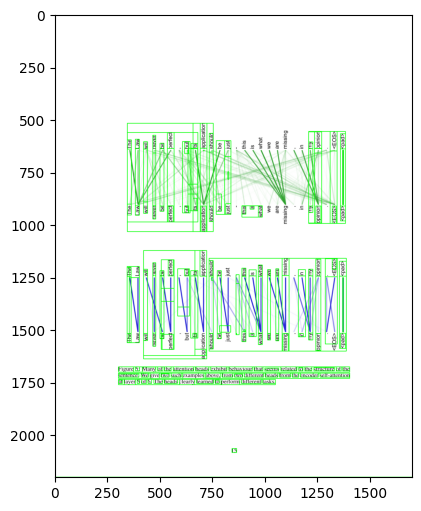

In [36]:
# extract page text with coordiate 
def extractPageImgTextWithCoord(pageImg):
    data = pytesseract.image_to_data(pageImg, output_type="dict")
    print(data.keys())
    numBox = len(data['level'])
    cv2img =cv2.cvtColor(np.array(pageImg), cv2.COLOR_RGB2BGR)
    # draw bounding box 
    for i in range(numBox):
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        cv2.rectangle(cv2img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # cv2.imshow("Image", cv2img) # show image with bounding box in window
    # # cv2.imshow("test", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2img)
    plt.show()
    return data


extractData = extractPageImgTextWithCoord(page)


In [37]:
type(page)

PIL.PpmImagePlugin.PpmImageFile

In [38]:
type(page)

PIL.PpmImagePlugin.PpmImageFile

In [39]:
# cv2.imshow("page", page)

In [40]:
# text = pytesseract.image_to_string(page)

In [41]:
# reader1 =PdfReader(pdfFilePath1)
# type(reader1)

In [42]:
# numPage = len(reader1.pages)

In [43]:
# reader1

In [44]:
# currentPage=reader1.pages[0]

In [45]:
# print(currentPage.extract_text())

In [21]:
def getPDFText(pdfDoc):
    '''
    get pdf text from pdf docs
    '''
    text="" 
    pdf_reader= PdfReader(pdfDoc) #read pdf file
    for page in pdf_reader.pages: # loop through pdf pages 
            text+= page.extract_text() # extract text from page and add to text variable
    return  text # return text variable

#### Use PyPDFDirectoryLoader from Langchain load PDF files from DirectoryLoader
<https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/#using-pypdf>

In [22]:
def getPDFDocs(directory):
    '''
    use PyPDFDirectoryLoader to extract pdf document from directory
    '''
    loader = PyPDFDirectoryLoader(directory) 
    docs = loader.load()
    return docs #text # return text variable

In [48]:
docs =getPDFDocs(pdfDir)
docs

[Document(metadata={'source': '../test-document/yolo.pdf', 'page': 0}, page_content='Real-Time Flying Object Detection with YOLOv8\nDillon Reis*, Jordan Kupec, Jacqueline Hong, Ahmad Daoudi\nGeorgia Institute of Technology\ndreis7@gatech.edu*, jkupec3@gatech.edu, jhong356@gatech.edu, adaoudi3@gatech.edu\nAbstract\nThis paper presents a generalized model for real-time\ndetection of ﬂying objects that can be used for transfer\nlearning and further research, as well as a reﬁned model\nthat is ready for implementation. We achieve this by train-\ning our ﬁrst (generalized) model on a data set containing\n40 different classes of ﬂying objects, forcing the model to\nextract abstract feature representations. We then perform\ntransfer learning with these learned parameters on a data\nset more representative of “real world” environments (i.e.\nhigher frequency of occlusion, small spatial sizes, rotations,\netc.) to generate our reﬁned model. Object detection of ﬂy-\ning objects remains challengi

In [49]:
len(docs)

25

In [50]:
docs[0].metadata

{'source': '../test-document/yolo.pdf', 'page': 0}

# Document Data Analysis

## level 1 : Layout Analysis, extract/analysis document component


In [42]:
from ultralytics import YOLO


In [43]:

# Load a model
yoloModel = YOLO("yolov8n.pt")  # load an official model
# model = YOLO("path/to/best.pt")  # load a custom model

# Validate the model
# metrics = yoloModel.val()  # no arguments needed, dataset and settings remembered
# metrics.box.map  # map50-95
# metrics.box.map50  # map50
# metrics.box.map75  # map75
# metrics.box.maps  # a list contains map50-95 of each category

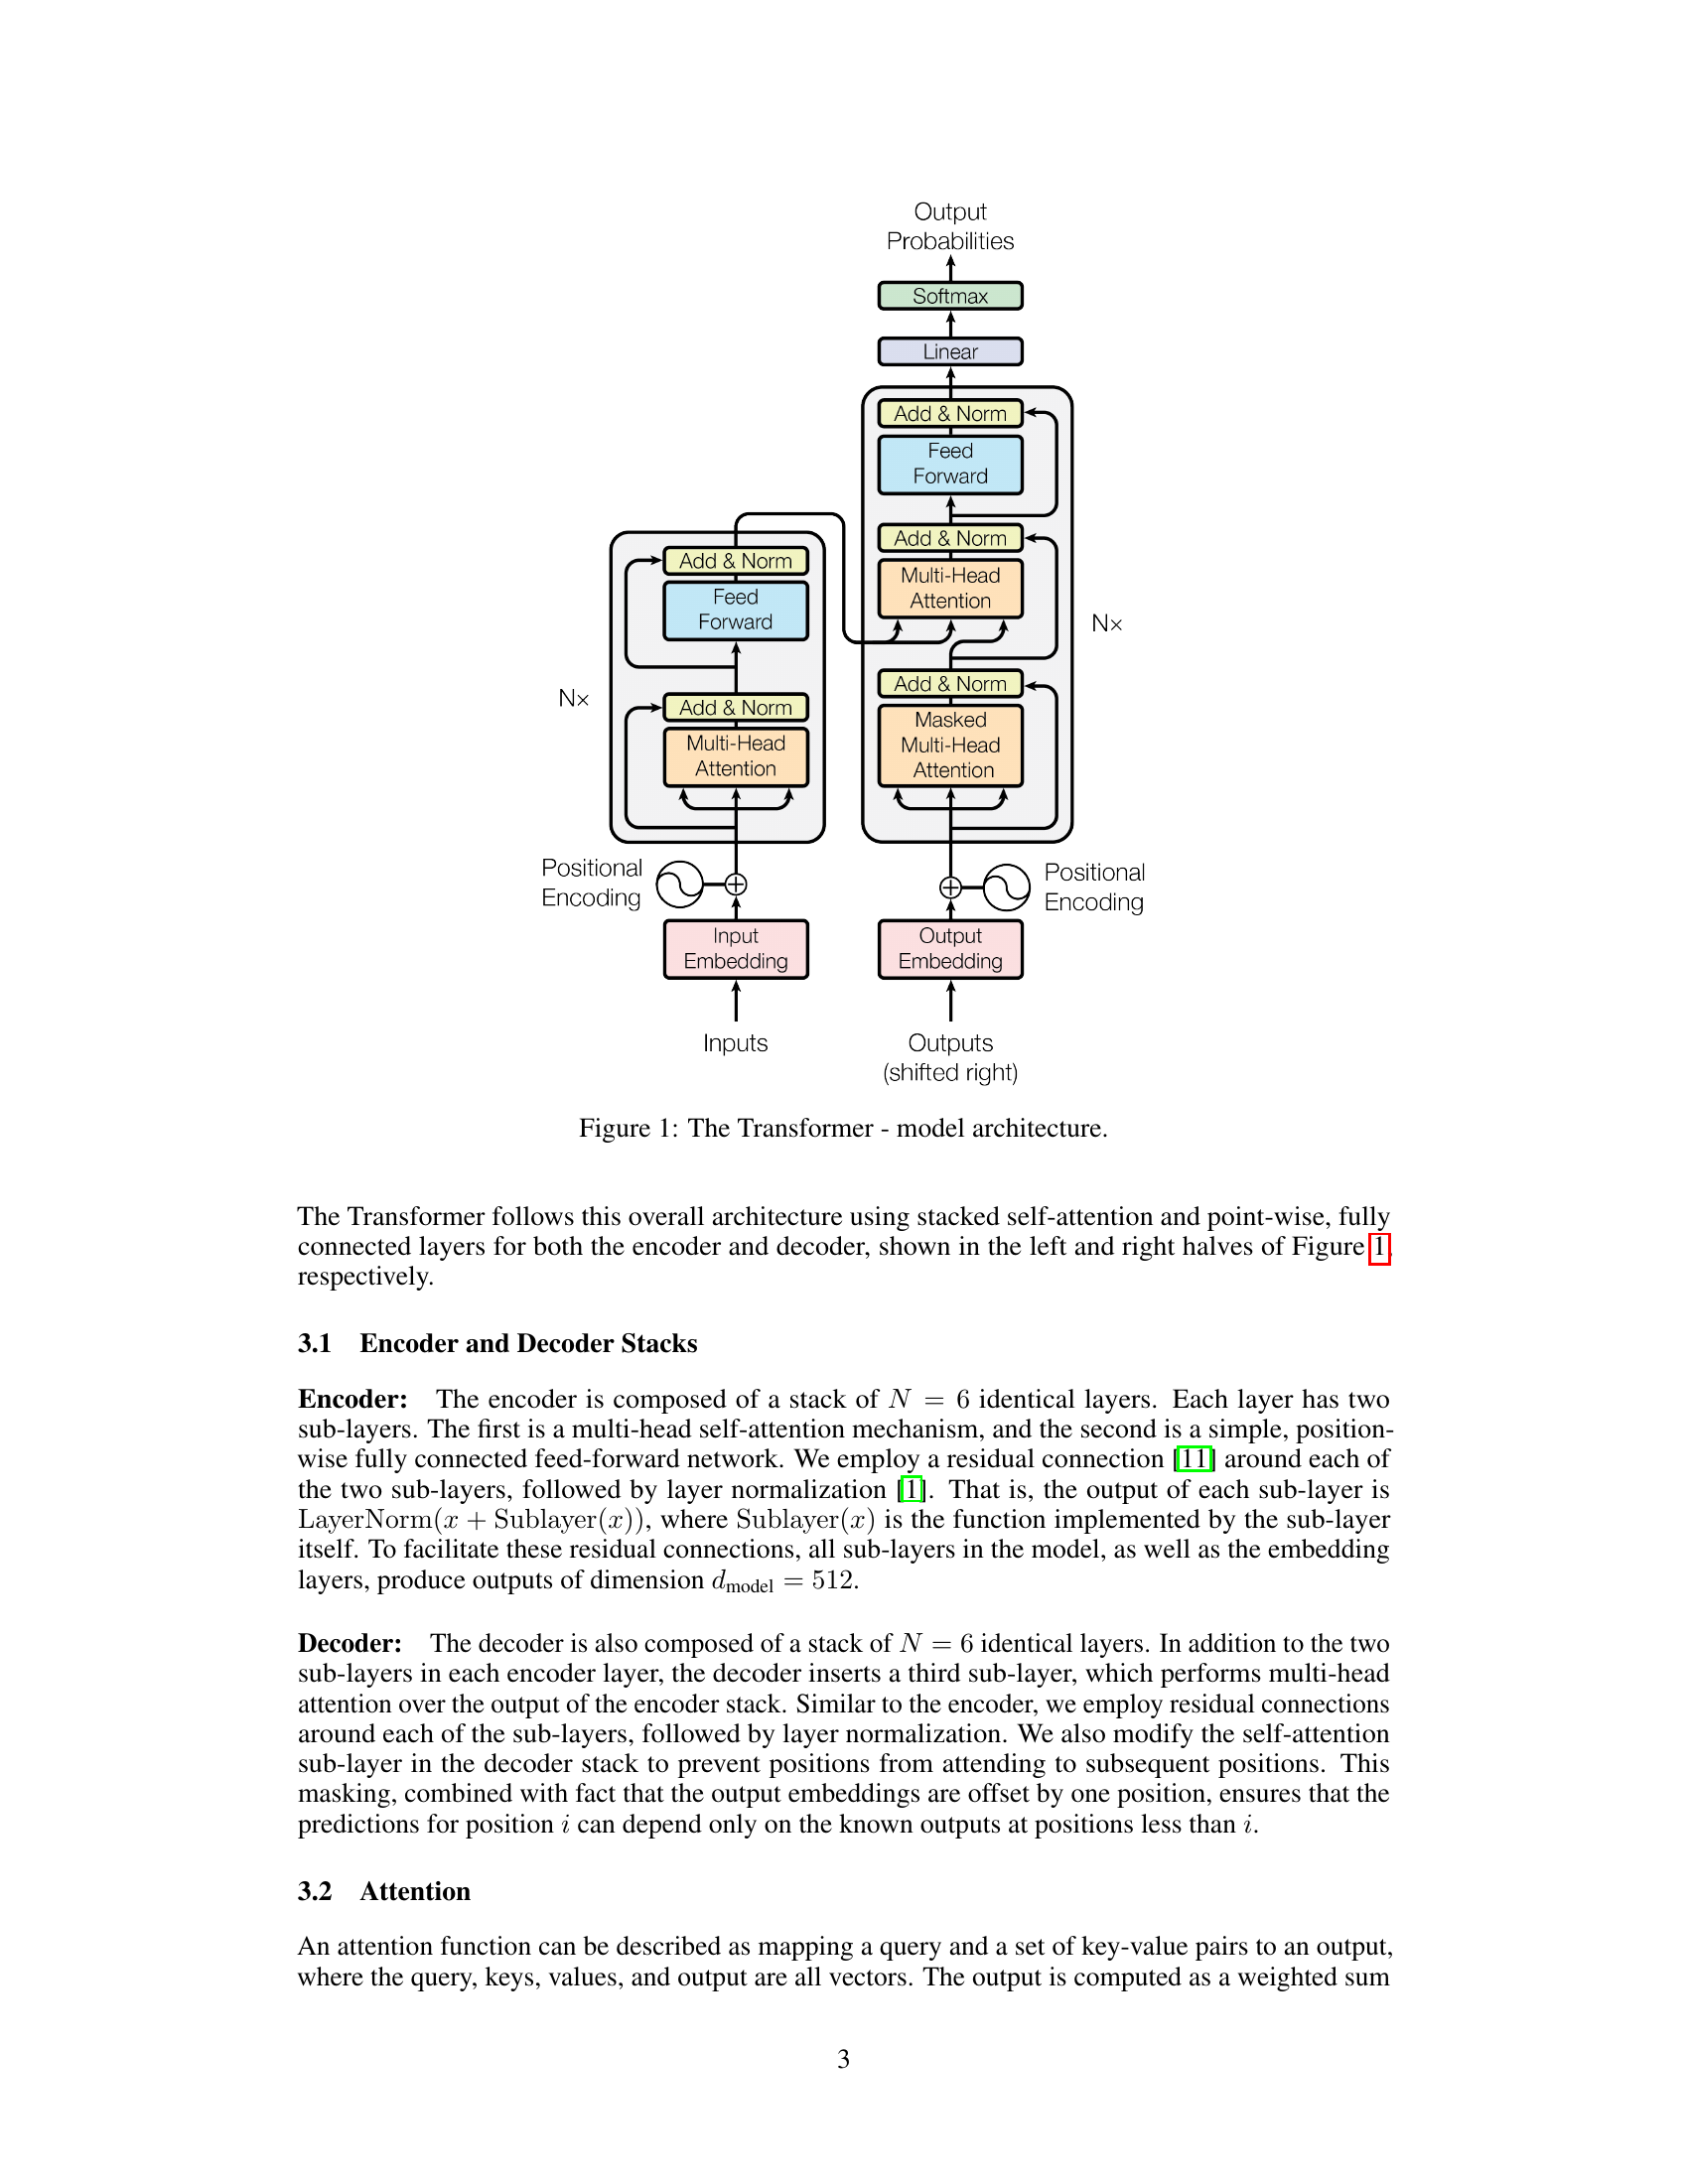

In [44]:
page3 = imgPdf[2]
page3 

In [45]:
result = yoloModel(page3)


0: 640x512 (no detections), 36.1ms
Speed: 3.4ms preprocess, 36.1ms inference, 15.8ms postprocess per image at shape (1, 3, 640, 512)


In [46]:
result

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

### level2 each component AI model extract data

# Level 3 Analysis task

## LLM Model Initialization

In [51]:
# Quantized Config for GPU support only
bnb_config = BitsAndBytesConfig(
        load_in_4bit = True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True # Activate nested quantization for 4-bit base models (double quantization)

)


In [52]:
# tokenizer = AutoTokenizer.from_pretrained(CFG.model2, token=huggingfaceToken)

In [61]:
if CFG.USE_LMSTUIDO:
    # Point to the local server
    from langchain.llms import OpenAI
    import openai
    llmModel = "LMStudio"
    model = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

else: # load model from huggingface
    if device.type == "cuda": # use 7b/8b/9b model gain performance
        if CFG.USE_LLAMA3:
            modelSel = CFG.model1
            llmModel = "llama3_8b"
        
        elif CFG.USE_GEMMA2:
            modelSel = CFG.model4
            llmModel = "gemma2_9b"
        
        elif CFG.USE_DEEPSEEK:
            modelSel = CFG.model5
            llmModel = "deepseek_1.5b"
        else:
            modelSel = CFG.model2
            llmModel = 'gemma_2b'
        
        if CFG.TASK_GEN:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto",  
                                                 quantization_config= bnb_config ,
                                                 token=huggingfaceToken)

        else:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto",  
                                                 quantization_config= bnb_config, token=huggingfaceToken)
        tokenizer = AutoTokenizer.from_pretrained(modelSel, token=huggingfaceToken) # inital tokenizer
        tokenizer.padding_side = "right"
    

    else: # for cpu select smaller model
        modelSel = CFG.model2
        llmModel = 'gemma_2b'
        if CFG.TASK_GEN:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto", token=huggingfaceToken)

        else:
            model = AutoModelForCausalLM.from_pretrained(modelSel, device_map="auto", token=huggingfaceToken)

        tokenizer = AutoTokenizer.from_pretrained(modelSel, token=huggingfaceToken) # inital tokenizer
        tokenizer.padding_side = "right"
    

In [ ]:


model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear4bit(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear4bit(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear4bit(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear4bit(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)


In [63]:
clearMemory()

In [64]:
llmModel


'deepseek_1.5b'

In [66]:
def delModel():
    global model, tokenizer
    del model
    del tokenizer
    clearMemory()

In [67]:
# delModel()

# Prompt Engineering

In [68]:

templatePrompt1 = """Question: {question}.\nOnly require given final result in JSON format with key 'answer'
            """
templatePrompt2 = "Answer the user Question.\n###\n{format_instructions}\n###\nQuestion: {query}\n"

templatePrompt3 = """
    Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, Answer is not available in the context, don't provide the wrong answer\n\n
    Context: {context}\n
    Question: {question}\n
    """

templatePrompt4 = """
Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in 
provided context just say, "answer is not available in the context", don't provide the wrong answer\n\n
CONTEXT: {context}
Provide answer and rethinking multiple step by step from Question: {question}
"""
templatePrompt5 = """
you are act as Mathematician, solve the math problem reasonable and logical from given question follow the requirement as below:
CONTEXT: {context}
Provide answer and rethinking multiple step by step from Question: {question}
Only Output answer in json format with key "answer" and "explanation" 
"""


In [69]:
print(templatePrompt5)


you are act as Mathematician, solve the math problem reasonable and logical from given question follow the requirement as below:
CONTEXT: {context}
Provide answer and rethinking multiple step by step from Question: {question}
Only Output answer in json format with key "answer" and "explanation" 



## Generate LLM response

In [77]:
async def generateResponse(query, maxOutToken=CFG.maxOutToken, topP=CFG.topP,
                          topK=CFG.topK, temperature = CFG.temperature
    ):
    """
    Direct send message to LLM model, get response
    """
    global model, tokenizer
    startTime = time.time()
    inputIds = tokenizer(query, return_tensors="pt").to(device)
    response = model.generate(**inputIds,
                              do_sample=True,
                              top_p=topP,
                              top_k = topK,
                              temperature=temperature,
                              max_new_tokens= maxOutToken,
                             )
    print(f"Time Taken : {time.time() - startTime}")
    # return tokenizer.decode(response[0][len(inputIds["input_ids"]):], skip_special_tokens = True)
    generatedIDs = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputIds.input_ids, response)
    ]
    # print(f"GeneratedIDs : {generatedIDs}")
    return tokenizer.batch_decode(generatedIDs, skip_special_tokens=True)[0]
    

def generateChatInstMsg(instruct, query):
    return   [
            {
            "role": "system",
            "content": instruct,
            },
            {"role": "user", 
             "content": query},
        ]

async def generateChatResponse(chatMsg ,maxOutToken=CFG.maxOutToken, topP=CFG.topP,
                          topK=CFG.topK, temperature = CFG.temperature):
    """
    send chat message to LLM
    """
    startTime = time.time()
    text = tokenizer.apply_chat_template(chatMsg, 
                                         tokenize=False, 
                                         add_generation_prompt=True)
    inputIDs = tokenizer(text, return_tensors="pt").to(device)
    response = model.generate(**inputIDs, 
                             do_sample=True,  #enable for Temperature 
                             top_p= topP,
                             top_k = topK,
                             temperature = temperature,
                             max_new_tokens=maxOutToken,
                             repetition_penalty= CFG.repetition_penalty)
    print(f"Time Taken : {time.time() - startTime}")
    generatedIDs = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputIDs.input_ids, response)
    ]
    # print(f"GeneratedIDs : {generatedIDs}")
    return tokenizer.batch_decode(generatedIDs, skip_special_tokens=True)[0]
    # return tokenizer.decode(response[0][len(inputIDs["input_ids"]):], skip_special_tokens=True)
    



## simple parser for extract data

In [78]:
import re
from  json.decoder import JSONDecodeError
if CFG.TASK_GEN:

    def isInteger(text):
        try:
            if int(text) >= 0:
                return True
            else:
                return False
        except ValueError:
            return False

    def llmJSONparser(txt, key="answer"):
        """
        try to get answer from LLM response , expect in JSON format, 
        """
        try:
            subText = txt.split("{") # split several {} in list 
            for txtSeg in subText: # loop in list to find answer
                end = txtSeg.find("}") # find end position in text segment
                sub = txtSeg[:end] #subsring with {} context
                print(sub)
                temp = sub.replace("*", "") # remove * symbol
                temp = temp.replace("\"", "") # reomve \" symbol
                temp = temp.lower() # convert to lower case
                answerloc = temp.find(key) # find key word "answer" position
                if answerloc != -1:
                    print(f"find answer location : {answerloc}")
                    newTxt = temp[answerloc:] # substring start answer
#                   print("Temp: ", temp)
                    subTxt = newTxt.split("\n")
                    #       print(subTxt)
                    rel =subTxt[0][len(key):].strip() # get answer value with remove space
                    rel= rel.replace(',', '') # remove , symbol
                    print(rel)
                    return rel
                
            return None # can't find answer
        except :
            print(f"""Error LLM JSON parser input txt {txt}""" )
            return None
        return None


    def getLLMAnswerParser(txt, key="answer:"):
        """
        when json parser failure, seem answer not JSON format, 
        use "answer" for key word search final answer 
        """
         # find answer  
        temp = txt.replace("*", "") # remove * symbol
        temp = temp.replace("\"", "") # reomve "" symbol
        temp = temp.lower() # convert to lower case
        # find answer key word
        start = temp.find(key)
        print(f"Start loc: {start}")
        subStr = temp[start:]
        if start != -1:
            subTxt = subStr.split("\n")
           #print(subTxt)
            rel =subTxt[0][len(key):].strip() # get answer value with remove space
            rel= rel.replace(',', '') # remove , symbol
            print(rel)
            return rel
    
        print(subStr)
        return None

## Add parser  to control extreact data from  LLM Structure Output

In [79]:
from langchain_core.output_parsers import (StrOutputParser, 
                                           JsonOutputParser,
                                           PydanticOutputParser,
                                          )
# for LLM structure output
from langchain_core.pydantic_v1 import BaseModel, Field, validator
# from pydantic import BaseModel, Field

### Test LLM Model

In [82]:

if CFG.TEST_LLM:
    ret =await generateResponse("What is Machine Learning?",    maxOutToken=1024, topP=0.95,
                          topK=10, temperature = 0.6)
    print(ret)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Time Taken : 22.537084579467773
 (I need to explain the answer in simple English, but in the correct way)
I need to make a simple explanation in simple English, but in the correct way. I need to avoid technical jargon.

I need to structure the answer in the following way: Introduction, Definition, Explanation, Benefits, Use Cases, Conclusion.

Also, the introduction should state that machine learning is a type of AI, but I need to explain it in simple terms.

The definition should be in simple English, without any technical terms.

The explanation should be clear, without any jargon.

The Benefits and Use Cases should be in simple English, without any jargon.

The conclusion should be in simple English, summarizing the key points.

I need to make sure that the language is simple but clear, avoiding any complex terms.

I also need to ensure that the explanation is accurate and doesn't make any mistakes in the concepts.

I need to use examples in the explanation to make it clearer.

I ne

In [83]:
Markdown(ret)

 (I need to explain the answer in simple English, but in the correct way)
I need to make a simple explanation in simple English, but in the correct way. I need to avoid technical jargon.

I need to structure the answer in the following way: Introduction, Definition, Explanation, Benefits, Use Cases, Conclusion.

Also, the introduction should state that machine learning is a type of AI, but I need to explain it in simple terms.

The definition should be in simple English, without any technical terms.

The explanation should be clear, without any jargon.

The Benefits and Use Cases should be in simple English, without any jargon.

The conclusion should be in simple English, summarizing the key points.

I need to make sure that the language is simple but clear, avoiding any complex terms.

I also need to ensure that the explanation is accurate and doesn't make any mistakes in the concepts.

I need to use examples in the explanation to make it clearer.

I need to avoid any markdown or formatting beyond what's specified.

I need to make sure that the conclusion is a summary of the key points without adding any extra information.

Also, the introduction should clearly explain what machine learning is, in simple terms.

The definition should be straightforward, without any complicated sentences.

The explanation should be easy to understand, using simple language and examples.

The Benefits and Use Cases should be in simple English, explaining how machine learning benefits people and businesses.

The conclusion should be a concise summary of the entire topic.

I need to make sure that the explanation is accurate and covers all the key points without any errors.

I need to avoid any technical jargon or terms that might confuse the reader.

I need to use examples to clarify the concepts.

I need to ensure that the explanation is clear and that each section flows logically to the next.

I need to make sure that the language is simple but clear, without any complexity.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a summary of the key points.

I need to make sure that the explanation is accurate and covers all the key points.

I need to make sure that the explanation is clear and understandable for someone who might not be familiar with machine learning.

I need to avoid any jargon or technical terms that might confuse the reader.

I need to use examples to make the concepts clearer.

I need to ensure that the explanation is accurate and that each section is explained in a way that is easy to understand.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a summary of the entire topic.

I need to ensure that the explanation is clear, accurate, and easy to understand.

I need to avoid any confusion or mistakes in the concepts.

I need to make sure that the explanation is correct and accurate.

I need to avoid any jargon or technical terms.

I need to use simple examples to clarify the concepts.

I need to make sure that the explanation is clear and that each section flows logically.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a concise summary of the key points.

I need to ensure that the explanation is accurate and covers all the key points without any errors.

I need to make sure that the explanation is clear and understandable.

I need to avoid any confusion or mistakes.

I need to make sure that the explanation is correct and accurate.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a summary of the entire topic.

I need to ensure that the explanation is clear, accurate, and easy to understand.

I need to avoid any confusion or mistakes.

I need to make sure that the explanation is correct and accurate.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a concise summary of the key points.

I need to ensure that the explanation is clear, accurate, and easy to understand.

I need to avoid any confusion or mistakes.

I need to make sure that the explanation is correct and accurate.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a concise summary of the entire topic.

I need to ensure that the explanation is clear, accurate, and easy to understand.

I need to avoid any confusion or mistakes.

I need to make sure that the explanation is correct and accurate.

I need to make sure that the language is simple but clear.

I need to avoid any markdown or formatting beyond the specified.

I need to make sure that the conclusion is a concise summary of the key points.

I need to ensure that the explanation is clear, accurate, and easy to understand.

I

In [84]:
msg1 = generateChatInstMsg("You are a intelligent Chatbot response to answer user query", 
                           "What is LLM model use case?")

In [87]:
ret = await generateChatResponse(msg1, maxOutToken=1024, topP=0.95,
                          topK=20, temperature = 0.6)
Markdown(ret)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Time Taken : 21.86309552192688


Okay, so I need to figure out what the different use cases of an LLM model are. I'm not too familiar with LLMs, but I know they're related to language models, which are programs that can understand and generate human language. LLMs are often used in AI applications.

First, I think about how LLMs can be used in general. They might help with tasks like answering questions, providing information, or even assisting with creative writing. But I should probably break this down into more specific areas.

Maybe I can start by thinking about common tasks people do that LLMs can help with. For example, in education, maybe an LLM could help students with homework by understanding the question and providing explanations. Or in healthcare, it could assist doctors in interpreting medical texts or helping patients with their health-related questions.

I also remember hearing about chatbots. Those are systems that interact with users over a conversation. Maybe LLMs can enhance chatbots to be more intelligent, able to understand and respond to complex queries. That sounds useful for businesses that want to engage customers in real-time chat.

Another thought is about generating content. If you have a question, an LLM could create detailed answers, like explaining scientific concepts or writing essays. That would be handy for students or researchers who need concise, accurate information quickly.

In the realm of creativity, perhaps LLMs can generate unique pieces of art or music. I've seen examples where AI artists are used in museums or art collections. So, creating something new for creative purposes could be a use case.

Personalization is another area. With LLMs, maybe people can tailor recommendations based on their preferences. For example, finding the perfect book or movie recommendation or suggesting products tailored to someone's lifestyle.

Education-wise, LLMs could help with grading by summarizing papers or checking for plagiarism. They might also assist teachers by providing feedback or creating lesson plans.

In the entertainment industry, AI could help in creating content like movies or games. An LLM might generate characters or plot ideas for a film or simulate dialogue for a game.

For businesses, LLMs could aid in decision-making by analyzing data and providing insights. For instance, predicting market trends or diagnosing equipment failures using historical data.

Healthcare is another field where LLMs can offer specialized services. They might help in drug discovery, developing personalized medicine plans, or analyzing medical images to diagnose diseases.

In the retail sector, personal assistants could make shopping easier by suggesting products or providing product recommendations. Also, chatbots powered by LLMs could help in managing customer interactions, such as sending reminders or handling returns.

Lastly, in the legal field, LLMs might help in organizing cases by classifying them, assisting in drafting contracts, or providing expert summaries for legal documents.

Wait, did I cover all these areas? Let me see: education, healthcare, chatbots, content generation, creativity, personalization, grading, entertainment, business, healthcare, retail, legal, and education again. Hmm, some areas repeat, but overall, it seems comprehensive.
</think>

LLM models have a wide range of application areas, each leveraging their ability to understand and generate human language to provide solutions across various fields. Here's a structured overview of the use cases:

1. **Education**: Assist students with homework by providing detailed explanations and answers, especially in subjects like mathematics, science, and literature.

2. **Healthcare**: Enhance medical assistance by interpreting texts, diagnosing diseases, and offering personalized treatment plans.

3. **Chatbots**: Develop intelligent chatbots to interact with users in real-time, improving customer service and response times.

4. **Content Generation**: Create detailed, accurate content for educational materials, scientific research, and creative endeavors.

5. **Creativity**: Generate unique art, music, and literature using AI tools, aiding in cultural preservation and innovation.

6. **Personalization**: Tailor recommendations to individual preferences, enhancing user experience in platforms like e-commerce and learning management systems.

7. **Education**: Provide tools for grading, plagiarism detection, and feedback, supporting teachers and students alike.

8. **Entertainment**: Create content for films, games, and other media, offering original works and character designs.

9. **Business**: Analyze data to inform strategic decisions, predict trends, and diagnose operational issues.

10. **Healthcare**: Assist in drug discovery, medical imaging analysis, and disease diagnosis through specialized AI services.

11. **Retail**: Offer personalized shopping recommendations and manage customer interactions with chatbots, providing reminders and support.

12. **Legal**: Organize legal cases, assist in contract drafting, and summarize legal documents efficiently.

These use cases highlight the versatility of LLMs across diverse industries, from education and healthcare to entertainment and retail, demonstrating their potential to enhance efficiency and effectiveness across the board.

In [86]:
if CFG.TEST_LLM:
    display(Markdown(ret)) # display in

Okay, so I need to figure out what LLM models are used for. I remember hearing about LLMs before, but I'm not exactly sure what they are or how they're used. Let me start by breaking down the term.

"LLM" stands for Large Language Model. From what I know, it's a type of AI that can understand and generate human language. So, it's like a machine that can talk or write in a way that sounds natural. But how does it work?

I think LLMs are trained on vast amounts of text data. They learn patterns and rules from this data to generate responses. But how do they actually do that? Maybe they use some kind of neural network, which I've heard

In [58]:
%%time
query = "What is Machine Learning?"
newPrompt = PromptTemplate(template=templatePrompt1,
                           input_variables=["question"])
finalPrompt = newPrompt.format(
                question=query    
            )
rel =generateResponse(finalPrompt, maxOutToken=1024)
print(rel)
# jsonTxt = getLLMAnswerParser(rel, key="answer")
# print(f"Question : {query}\nResponse Answer: {jsonTxt}")

Question: What is Machine Learning?.
Only require given final result in JSON format with key 'answer'
            {
                'answer': 'Machine learning is a branch of artificial intelligence that enables computers to learn from data without explicit programming. It involves training algorithms on datasets to identify patterns, make predictions, and improve their performance over time.'
            }

CPU times: user 1.84 s, sys: 8.14 ms, total: 1.85 s
Wall time: 1.84 s


## Prepare RAG 

In [59]:
# Defin RAG alogrithm
USE_SIMPLE_RAG = True#True# True # simple similairy approach 
USE_RERANK = False #False # advance RAG with Re-Ranking 
USE_QUERY_EXPANSION = False   # advance RAG with 
USE_EMBEDDING_ADAPER = False
if CFG.USE_WANDB: # define wandb RAG project name
    if USE_SIMPLE_RAG:
        wandbRAGProject = "ai-bank-statement-simple-rag"
    elif USE_RERANK:
        wandbRAGProject = "ai-bank-statement-re-ranking"
    elif USE_QUERY_EXPANSION:
        wandbRAGProject = "ai-bank-statement-query-expansion"
    elif USE_EMBEDDING_ADAPER:
        wandbRAGProject = "ai-bank-statement-embedding-adapter"
    else:
        wandbRAGProject = "ai-bank-statement-simple-rag"

In [60]:
if CFG.USE_WANDB:
     # Start a new wandb run
    runTask1 = wandb.init(project=wandbRAGProject, job_type="generation", anonymous="allow")
    # define W&B Table
    wandbCol1 =  ["model", "question",  "llm_generate", "llm_answer"]
    wandbRAGTable =wandb.Table(columns=wandbCol1)

## Convert Text To Langchain Document

In [61]:
from langchain_core.documents import Document

In [62]:
def convertText2Document(content, source):
    """
    Convert text to Document object
    """
    doc = Document(
        page_content= content, 
        metadata= {"sources": source}
        )
    return doc

## inital Embedding Model

In [63]:
if device.type == "cuda":
    model_kwargs = {"device": "cuda"}
    multiProcess=  False#True #  for multi-GPU
else:
    model_kwargs = {"device": "cpu"}
    multiProcess= False
def embeddingModelInit(modelName):
        embed =  HuggingFaceEmbeddings(model_name=modelName, model_kwargs= model_kwargs, multi_process=multiProcess)#initial embedding model 
        return embed

In [64]:
embedding = embeddingModelInit(CFG.embedModel2)

In [65]:
vector= embedding.embed_query("Hello, how are you?")
len(vector) # checking vector length

1024

# Text split into Chunking 

In [66]:
from langchain_text_splitters import (RecursiveCharacterTextSplitter,
                                      CharacterTextSplitter,
                                      MarkdownHeaderTextSplitter,
                                      HTMLHeaderTextSplitter,
                                      HTMLSectionSplitter)

In [67]:
def textSplitterByText(txt, chunkSize= 512, overlap=20, separators=["\n\n"]):
    """
    Split text by chunk size
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunkSize,
        chuck_overlap=overlap,
        separators=separators,
        length_function=len,
        is_separator_regex=False,
        # start_with_newline=True,
        # add_start_index=True,
        # add_end_index=True,
    )
    splittedTxt = splitter.split_text(txt)
    return splittedTxt


def textSplitterByDocs(docs, chunkSize= 512, overlap= 20, separators=["\n\n"]):
    textSplitter = RecursiveCharacterTextSplitter(
        chunk_size = chunkSize,
        chunk_overlap = overlap,
        separators=separators,
        length_function = len,
        is_separator_regex =False
    )
    splitted = textSplitter.split_documents(docs)
    return splitted

In [68]:
if USE_SIMPLE_RAG:
    textSplitter = RecursiveCharacterTextSplitter(
                                chunk_size= 800, #1500,
                                chunk_overlap=20, #100,
                                add_start_index=True,
                                separators=["\n\n", "\n", ".", " ", ""],
                                  length_function=len,
                                is_separator_regex=False)
else: # advance RAG possabile use adv method
    textSplitter = CharacterTextSplitter(chunk_size=1500, 
                                             chunk_overlap=100,
                                             length_function=len,
                                             separator="\n\n",
                                             is_separator_regex=False)
        

In [69]:
def splitTextDataFromText(text):
    chunk = textSplitter.split_text(text)
    return textSplitter.create_documents(chunk) # create docs
    
def chunkText(docs, chunkSize=800, chunkOverlap=50):
    # Split text into chunks
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunkSize, chunk_overlap=chunkOverlap)
    chunks = splitter.split_documents(docs)
    return chunks
        

In [70]:
# len(rawTxt1)
# docList = splitTextDataFromText(rawTxt1)
# len(docList)

In [71]:
len(docs)

25

In [72]:
chunkedDocs = textSplitterByDocs(docs, chunkSize=1500, overlap=50, separators=["\n\n", "\n"]) # chunk text into documents
chunkedDocs

[Document(metadata={'source': '../test-document/yolo.pdf', 'page': 0}, page_content='Real-Time Flying Object Detection with YOLOv8\nDillon Reis*, Jordan Kupec, Jacqueline Hong, Ahmad Daoudi\nGeorgia Institute of Technology\ndreis7@gatech.edu *, jkupec3@gatech.edu, jhong356@gatech.edu, adaoudi3@gatech.edu\nAbstract\nThis paper presents a generalized model for real-time\ndetection of ﬂying objects that can be used for transfer\nlearning and further research, as well as a reﬁned model\nthat is ready for implementation. We achieve this by train-\ning our ﬁrst (generalized) model on a data set containing\n40 different classes of ﬂying objects, forcing the model to\nextract abstract feature representations. We then perform\ntransfer learning with these learned parameters on a data\nset more representative of “real world” environments (i.e.\nhigher frequency of occlusion, small spatial sizes, rotations,\netc.) to generate our reﬁned model. Object detection of ﬂy-\ning objects remains challeng

In [73]:
len(chunkedDocs)

65

In [74]:
chunkedDocs[0].metadata

{'source': '../test-document/yolo.pdf', 'page': 0}

## Store Document in VectorDB
### langchain new version required different vector database install different vector database libraries and Call API
### for Chroma
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/>

### for Pinecone
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/pinecone/>

### for FAISS
<https://python.langchain.com/v0.2/docs/integrations/vectorstores/faiss/>

In [75]:
documentIDs = []

In [76]:
%%time
from uuid import uuid4
from langchain_chroma import Chroma
import time
# VectorDB inital and store document into Vector DB
if CFG.USE_CHROMA:
        
        def chormaDBInit(collectionName, embedding, persitDict="./chroma_db"):
            chromadb = Chroma(collection_name=collectionName,
                                embedding_function=embedding, 
                                persist_directory=persitDict)
            return chromadb
        
        def addDocIDs(ids):
            documentIDs.extend(ids)

        def removeDocIDs(idx):
            documentIDs.remove(idx)

        def generateDocIDs(numDoc=1):
            uuids= []
            for _ in range(numDoc):
                uuids.append( str(uuid4()))
                addDocIDs(uuids)
             # print(f"UUIDS : {uuids}")
            return uuids
        
        def saveToChroma(db, chuck: list[Document]):
            db.add_documents(chuck)

        async def saveToChromaIDAsyc(db, chuck: list[Document]):
            startTime = time.time()
            uuids = generateDocIDs(len(chuck))
            await db.aadd_documents(chuck, ids=uuids)
            print(f"Time Taken:  {time.time() - startTime}")
        

        def saveToChromaID(db, chuck: list[Document]):
            # generate document ID 
            uuids = generateDocIDs(len(chuck))
            db.add_documents(chuck, ids=uuids)

        def delChroma(db, idx):
            db.delete(ids=idx)

        def delChromaAll(db):
            db.delete(ids=documentIDs)


        def vectorDBsimilaritySearchWithScores(db, query, k =3):
            results = db.similarity_search_with_relevance_scores(query, k=k)
            return results

        def vectorDBsimilaritySearch(db, query, k=3):
            results = db.similarity_search(query, k=k)
            return results


        def vectorDBsimilaritySearchByVector(db, query, embed, k=3 ):
            results = db.similarity_search_by_vector(
            embedding=embed.embed_query(query), k=k)
            return results

        def vectorDBSimilaritySearchByMMR(db, query, k=3, fetchK=20):
            results = db.max_marginal_relevance_search(query=query, k=k, fetch_k=fetchK)
            return results

        db = chormaDBInit("bank-statement", embedding, persitDict="./chroma_db")
        saveToChromaID(db, chunkedDocs)
        # db = Chroma.from_documents(documents= chunkedDocs, embedding=embedding, persist_directory="./chroma_db")
elif CFG.USE_FAISS:
        db = FAISS.from_documents(documents =chunkedDocs, embedding= embedding)
        print(db.index.ntotal) # number of total index size
elif CFG.USE_PINECONE:
        from pinecone import Pinecone, ServerlessSpec
        from langchain_pinecone import PineconeVectorStore
        os.environ['PINECONE_API_KEY'] = os.getenv("PINECONE_API_KEY")# 
        pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

        import time

        index_name = "langchainvector2"  # piecond  db index name , can change if desired

        existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

        if index_name not in existing_indexes:
            pc.create_index(
                name=index_name,
                dimension=1024,#768,
                metric="cosine",
                spec=ServerlessSpec(cloud="aws", region="us-east-1"),
            )
            while not pc.describe_index(index_name).status["ready"]:
                time.sleep(1)

        index = pc.Index(index_name)
        # Connect to Pinecone index and insert the chunked docs as contents
        db =PineconeVectorStore.from_documents(chunkedDocs, embedding, index_name=index_name)

CPU times: user 1.71 s, sys: 38.5 ms, total: 1.75 s
Wall time: 1.67 s


In [77]:
db

# 


# Test Query for Vector DB

In [78]:
query = "What is Yolo?"
# results = db.similarity_search(query)


results = vectorDBsimilaritySearchWithScores(db, query, k=3)

In [79]:
results[0][0].metadata

{'page': 9, 'source': '../test-document/yolo.pdf'}

## Setup RAG Top K

In [80]:
if USE_SIMPLE_RAG:
        num_docs= 2 # set max top k=  3 rank similarity  
elif  USE_RERANK:
        num_docs =15 # re-ranking use highter order 
else: 
        num_docs =3

# set retriever
retriever  = db.as_retriever( 
                search_type="mmr",  # Also test "similarity"
                search_kwargs={"k": num_docs})

In [81]:
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x72d454fc9b10>, search_type='mmr', search_kwargs={'k': 2})

## Test for VectorDB with retriever

In [82]:
query = "What is Yolo?"
results = retriever.invoke(query)
print(len(results))
print(results)

2
[Document(metadata={'page': 9, 'source': '../test-document/yolo.pdf'}, page_content='Farhadi. You only look once: Uniﬁed, real-time ob-\nject detection, 2016. Supplied as additional material\nhttps://arxiv.org/pdf/1506.02640.pdf . 7\n[13] Joseph Redmon and Ali Farhadi. Yolov3: An incremental\nimprovement. CoRR , abs/1804.02767, 2018. 4\n[14] Dillon Reis, Jacqueline Hong, Jordan Kupec, and Ahmad\nDaoudi. Real time ﬂying object detection code repository.\n1\n[15] Zion Market Research. Global drone market size to register\ncagr of about 38.75 percent over 2023-2030, 2023. March\n15 2023. 1\n[16] Jacob Solawetz and Francesco. What is yolov8? the ultimate\nguide., 2023. 04-30-2023. 1, 5, 8\n[17] Emma Soteriou. Ukraine ’tried to assassinate putin using\ndrone loaded with explosives’ but it crashed miles from tar-\nget, 2023. 27 April 2023. 1\n[18] Juan R. Treven and Diana M. Cordova-Esparaza. A\ncomprehensive review of yolo: From yolov1 to yolov8\nand beyond, 2023. Supplied as additional m

## LLM RAG Test

In [83]:
# from langchain.chains.question_answering import load_qa_chain

In [84]:
# chain=load_qa_chain(model ,chain_type="stuff")

In [85]:
userQuery="What is YOLO"

In [86]:
def ragAnswerLLM(query, retriever):
        newPrompt = PromptTemplate(template=templatePrompt3, 
                               input_variables=["context", "question"])
        ragContext= ""
        resultRAG = retriever.invoke(query)
        print(len(resultRAG))
        for i, res in enumerate(resultRAG): # loop RAG result
            ragContext +=  res.page_content + "\n" #f"Context {i+1} : {res['document']}\n"

        # print("RAG result: ", ragContext)
        finalPrompt = newPrompt.format(
            context=ragContext,
            question=query
        )
        # finalPrompt = query
        print(finalPrompt)
        response = generateResponse(finalPrompt, maxOutToken=256)

        return response

In [87]:
regAnswer = ragAnswerLLM(userQuery, retriever)
print(regAnswer)

2

    Answer the question as detailed as possible from the provided context, make sure to provide all the details, if the answer is not in
    provided context just say, Answer is not available in the context, don't provide the wrong answer


    Context: Farhadi. You only look once: Uniﬁed, real-time ob-
ject detection, 2016. Supplied as additional material
https://arxiv.org/pdf/1506.02640.pdf . 7
[13] Joseph Redmon and Ali Farhadi. Yolov3: An incremental
improvement. CoRR , abs/1804.02767, 2018. 4
[14] Dillon Reis, Jacqueline Hong, Jordan Kupec, and Ahmad
Daoudi. Real time ﬂying object detection code repository.
1
[15] Zion Market Research. Global drone market size to register
cagr of about 38.75 percent over 2023-2030, 2023. March
15 2023. 1
[16] Jacob Solawetz and Francesco. What is yolov8? the ultimate
guide., 2023. 04-30-2023. 1, 5, 8
[17] Emma Soteriou. Ukraine ’tried to assassinate putin using
drone loaded with explosives’ but it crashed miles from tar-
get, 2023. 27 April 202

In [88]:
documentIDs

['6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '81987ae5-1c57-4dc0-a551-48c16f52d0d1',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '81987ae5-1c57-4dc0-a551-48c16f52d0d1',
 '867bbd1c-7b6e-4262-a6a0-5d442d52d25d',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '81987ae5-1c57-4dc0-a551-48c16f52d0d1',
 '867bbd1c-7b6e-4262-a6a0-5d442d52d25d',
 'af719f5e-d5c9-459d-8a16-7a9b0e5bc288',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '81987ae5-1c57-4dc0-a551-48c16f52d0d1',
 '867bbd1c-7b6e-4262-a6a0-5d442d52d25d',
 'af719f5e-d5c9-459d-8a16-7a9b0e5bc288',
 'c28a84d5-34d9-4ec8-a6d6-b7a271ac4bdf',
 '6ed4d0f6-ba35-47c8-8d3c-07c03829a702',
 '5c8b2ceb-e900-4946-a5ff-3bc4f3efbcf3',
 '81987ae5-1c57-4dc0-a551-48c16f52d0d1',
 '867bbd1c-7b6e-

In [90]:
# delChromaAll(db)